<a href="https://colab.research.google.com/github/venkatanadikatla/pytorch/blob/main/Hierarchical_Model_Energy_Efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Information**

https://archive.ics.uci.edu/dataset/242/energy+efficiency

We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

However, for this project - My aim to predict **heating Load** and use the "**Hierarchical Bayesian Model**"

**Additional Variable Information**
The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses.

**Specifically:**

**X1	Relative Compactness**

**X2	Surface Area**

**X3	Wall Area**

**X4	Roof Area**

**X5	Overall Height**

**X6	Orientation**

**X7	Glazing Area**

**X8	Glazing Area Distribution**

**y1	Heating Load**

**y2	Cooling Load**

**License**

This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.https://creativecommons.org/licenses/by/4.0/legalcode

This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given.

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

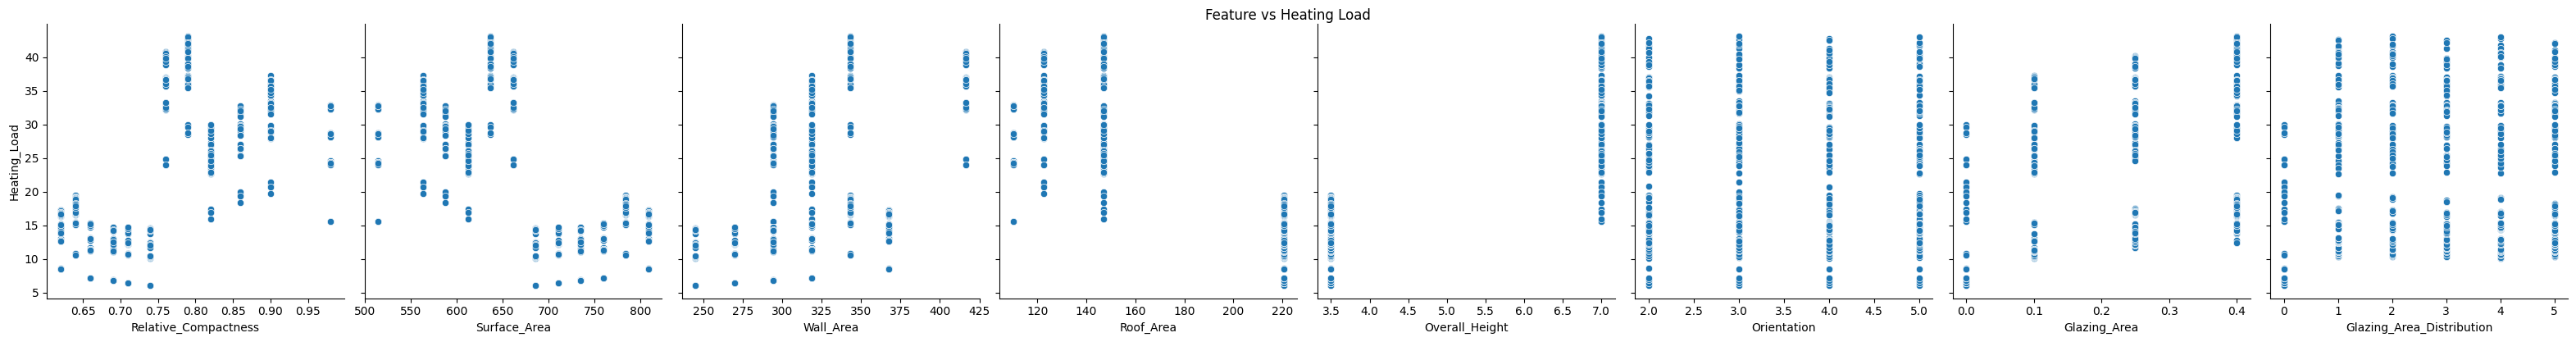

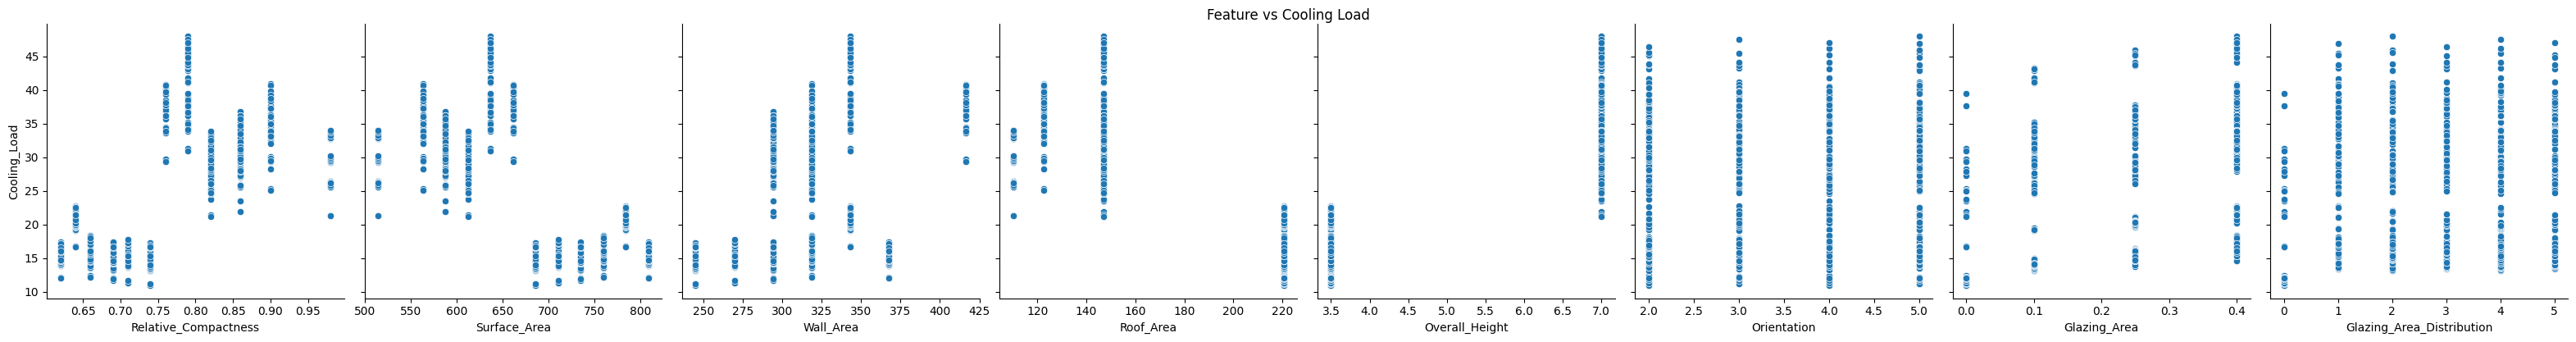

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to check linearity for heating load
sns.pairplot(df, x_vars=['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution'],
             y_vars='Heating_Load', height=4, aspect=1)
plt.suptitle('Feature vs Heating Load', y=1.02)
plt.show()

# Pairplot for cooling load
sns.pairplot(df, x_vars=['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution'],
             y_vars='Cooling_Load', height=4, aspect=1)
plt.suptitle('Feature vs Cooling Load', y=1.02)
plt.show()


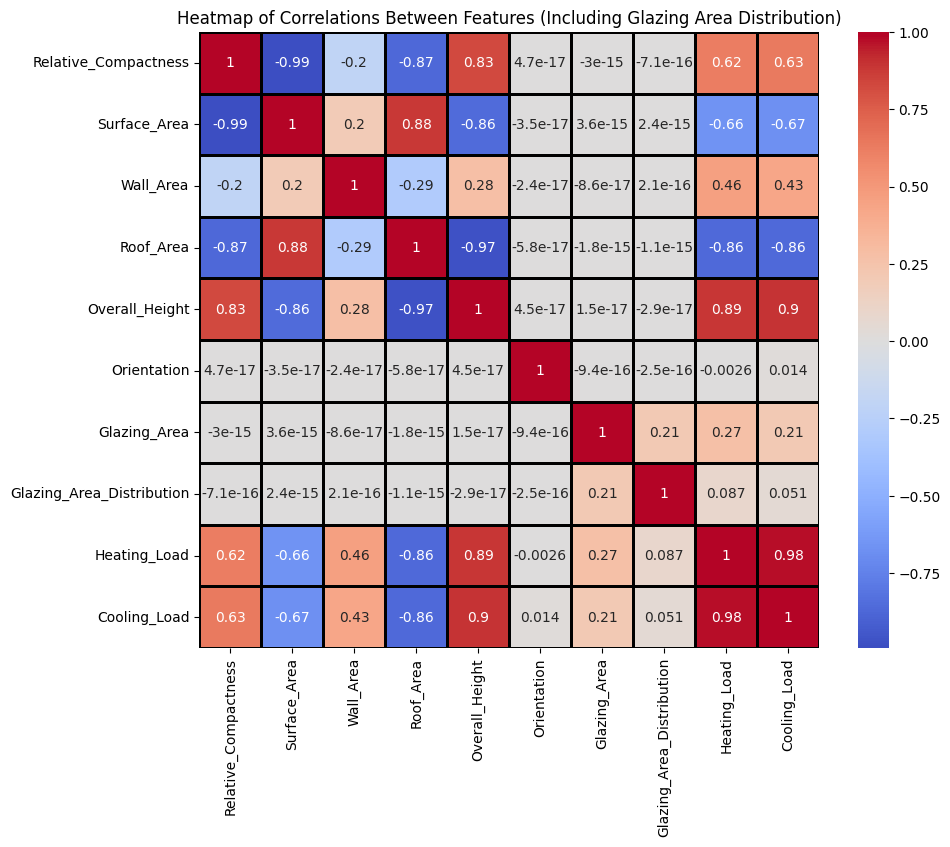

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant features for heatmap (including interactions)
interaction_features = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Create a new dataframe with these features
df_interaction = df[interaction_features]

# Generate the correlation matrix
corr_matrix_interaction = df_interaction.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_interaction, annot=True, cmap="coolwarm", center=0, linewidths=1, linecolor='black')
plt.title('Heatmap of Correlations Between Features (Including Glazing Area Distribution)')
plt.show()


In [ ]:
# Correlation matrix for heating load
corr_matrix_heating = df.corr()['Heating_Load']
print(corr_matrix_heating)

# Correlation matrix for cooling load
corr_matrix_cooling = df.corr()['Cooling_Load']
print(corr_matrix_cooling)


Relative_Compactness         0.622272
Surface_Area                -0.658120
Wall_Area                    0.455671
Roof_Area                   -0.861828
Overall_Height               0.889430
Orientation                 -0.002587
Glazing_Area                 0.269842
Glazing_Area_Distribution    0.087368
Heating_Load                 1.000000
Cooling_Load                 0.975862
Name: Heating_Load, dtype: float64
Relative_Compactness         0.634339
Surface_Area                -0.672999
Wall_Area                    0.427117
Roof_Area                   -0.862547
Overall_Height               0.895785
Orientation                  0.014290
Glazing_Area                 0.207505
Glazing_Area_Distribution    0.050525
Heating_Load                 0.975862
Cooling_Load                 1.000000
Name: Cooling_Load, dtype: float64


In [ ]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


# Select only the feature columns (exclude the target variable)
X = df[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation',
        'Glazing_Area', 'Glazing_Area_Distribution']]

# Standardize the features (optional but recommended to get better VIF results)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

# Print the VIF results
print(vif_data)


                     Feature         VIF
0       Relative_Compactness  105.524054
1               Surface_Area         inf
2                  Wall_Area         inf
3                  Roof_Area         inf
4             Overall_Height   31.205474
5                Orientation    1.000000
6               Glazing_Area    1.047508
7  Glazing_Area_Distribution    1.047508


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


**Mulitcollinearity**:

Since multicollinearity can distort the interpretation of this model, I want to remove some of the highly correlated features.
 * Remove features like Relative Compactness, Roof Area, and Surface Area, and keep only Overall Height (since it has the highest correlation with my target).

 Note: Alternatively, I can also use Principal Compoenent Analysis (PCA) to avoid multicollinearity but I am going to remove the features on this model instead of using PCA.

In [ ]:
df = df.drop(['Relative_Compactness','Roof_Area','Surface_Area'], axis=1)
df.head()
df.columns

Index(['Wall_Area', 'Overall_Height', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load'],
      dtype='object')

**Frequentist Linear Regression (Simple Linear Regression) without the Hierarchical Model**:

Below model is using sklearn's LinearRegression, which implements ordinary least squares linear regression. This is a basic linear model without any hierarchical structure

RMSE for Heating Load: 9.068626297706798


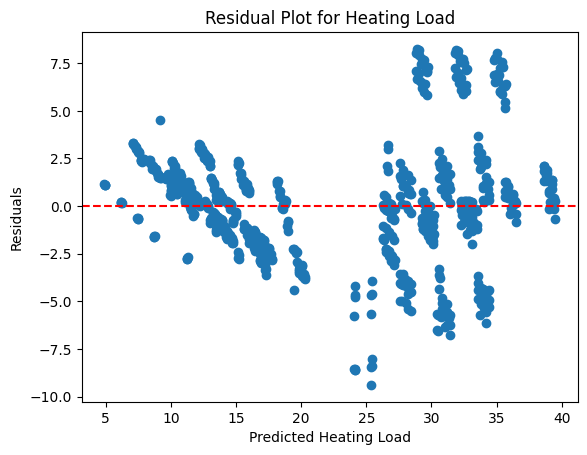

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define features and target for heating load
X = df[['Wall_Area', 'Overall_Height', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution']]
y_heating = df['Heating_Load']

# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y_heating)
y_pred = lin_reg.predict(X)

# Calculate residuals
residuals = y_heating - y_pred
# Optionally, calculate the RMSE
rmse_log = mean_squared_error(y_heating, y_pred)
print("RMSE for Heating Load:", rmse_log)

# Plot residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Heating Load')
plt.xlabel('Predicted Heating Load')
plt.ylabel('Residuals')
plt.show()


**Bayesian Linear Regression without the hierarchical model:** Provides probability distributions (posterior distributions) for the coefficients, allowing you to capture uncertainty about the model parameters. Instead of point estimates, you get entire distributions for each coefficient and the intercept, as well as predictions that account for uncertainty.

Output()

Output()

Output()

Output()

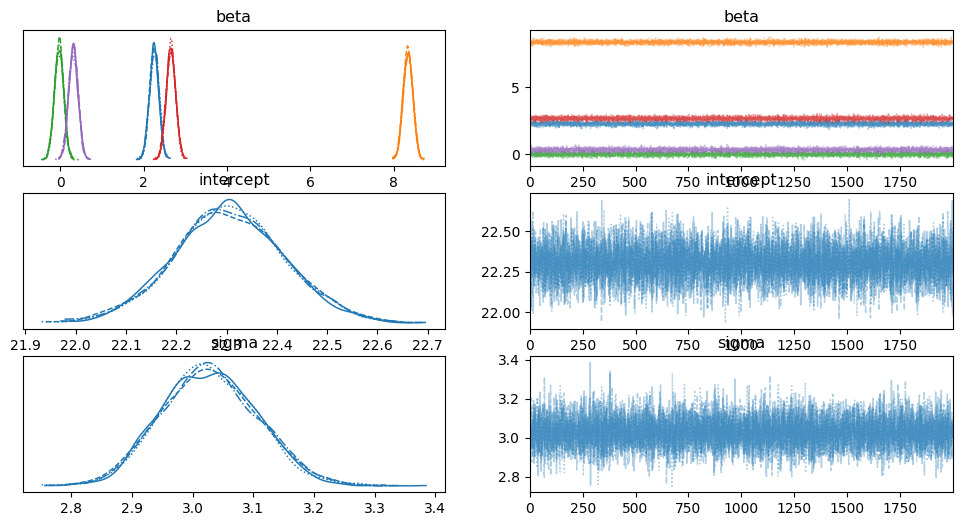

Output()

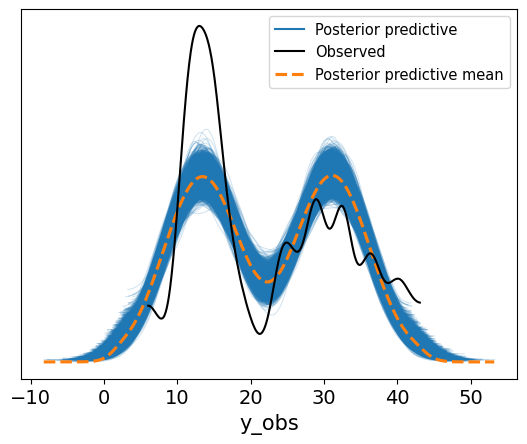

In [ ]:
import pymc as pm
import arviz as az
import numpy as np

# Standardize the input features for better performance in Bayesian models
X_standardized = (X - X.mean()) / X.std()

# Define the Bayesian Linear Regression Model
with pm.Model() as bayesian_lin_reg_model:
    # Priors for the regression coefficients (less informative priors)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_standardized.shape[1])

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=10)

    # Prior for the standard deviation of the noise
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Define the linear model
    mu_y = intercept + pm.math.dot(X_standardized, beta)

    # Likelihood (sampling distribution) of the observed data
    y_obs = pm.Normal('y_obs', mu=mu_y, sigma=sigma, observed=y_heating)

    # Sample from the posterior
    trace_bayesian_lin_reg = pm.sample(2000, tune=3000, chains=4, target_accept=0.95, return_inferencedata=True)

# Summarize the posterior distributions
az.summary(trace_bayesian_lin_reg, hdi_prob=0.95)

# Trace plot for visualizing convergence
az.plot_trace(trace_bayesian_lin_reg)
plt.show()

# Posterior predictive check
with bayesian_lin_reg_model:
    ppc_bayesian_lin_reg = pm.sample_posterior_predictive(trace_bayesian_lin_reg, return_inferencedata=True)

# Plot posterior predictive checks
az.plot_ppc(ppc_bayesian_lin_reg)
plt.show()


In [ ]:
# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace_bayesian_lin_reg)
print(rhat_values)

<xarray.Dataset> Size: 96B
Dimensions:     (beta_dim_0: 5)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 40B 0 1 2 3 4
Data variables:
    beta        (beta_dim_0) float64 40B 1.001 1.001 1.001 1.001 1.0
    intercept   float64 8B 1.0
    sigma       float64 8B 1.0


**Hierarchical Bayesian Modeling for Predicting Heating Load with Non-Linear Relationships**

In this analysis, I aim to predict Heating Load by accounting for non-linear relationships between the input features and the target variable. To capture these complexities, I employ a Hierarchical Bayesian model, incorporating both linear and quadratic (polynomial) terms to model non-linear patterns effectively.

The hierarchical structure allows us to account for variations in heating load across different Glazing Area Distributions, modeling both individual and group-level effects. This approach enhances prediction accuracy while providing a more interpretable framework for understanding how the features influence Heating Load.

**Model1**: **Bayesian Hierarchical Model with Polynomial Approach (Centered Parametrization)**

This model implements a Bayesian Hierarchical approach to predict Heating Load using both linear and quadratic (polynomial) terms to account for non-linear relationships in the input features. The hierarchical structure incorporates group-level effects, with glazing area distribution as the grouping factor. I use a centered parametrization where the group-level parameters (for each glazing area distribution) are modeled with Gamma distributions, while the individual-level coefficients for linear and quadratic terms are given Normal priors.

Posterior sampling is performed using PyMC, followed by convergence diagnostics and posterior predictive checks to assess model fit and performance.

Output()

Output()

Output()

Output()

                   mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha           241.279  375.215     0.329    883.085      9.024    6.382   
beta             14.012   15.466     0.130     42.393      0.346    0.245   
beta_linear[0]    2.141    0.116     1.918      2.372      0.001    0.001   
beta_linear[1]    8.372    0.110     8.164      8.589      0.001    0.001   
beta_linear[2]    1.021    7.036   -13.050     14.875      0.111    0.078   
beta_linear[3]   -0.028    0.104    -0.234      0.174      0.001    0.001   
beta_linear[4]    1.234    7.038   -12.514     15.365      0.111    0.078   
beta_linear[5]    0.518    0.596    -0.609      1.802      0.010    0.007   
beta_quad[0]      0.198    0.078     0.048      0.355      0.001    0.001   
beta_quad[1]      9.110    6.954    -4.403     21.082      0.261    0.200   
beta_quad[2]      0.028    7.109   -13.927     13.966      0.115    0.081   
beta_quad[3]     -0.014    0.128    -0.263      0.243      0.001    0.001   

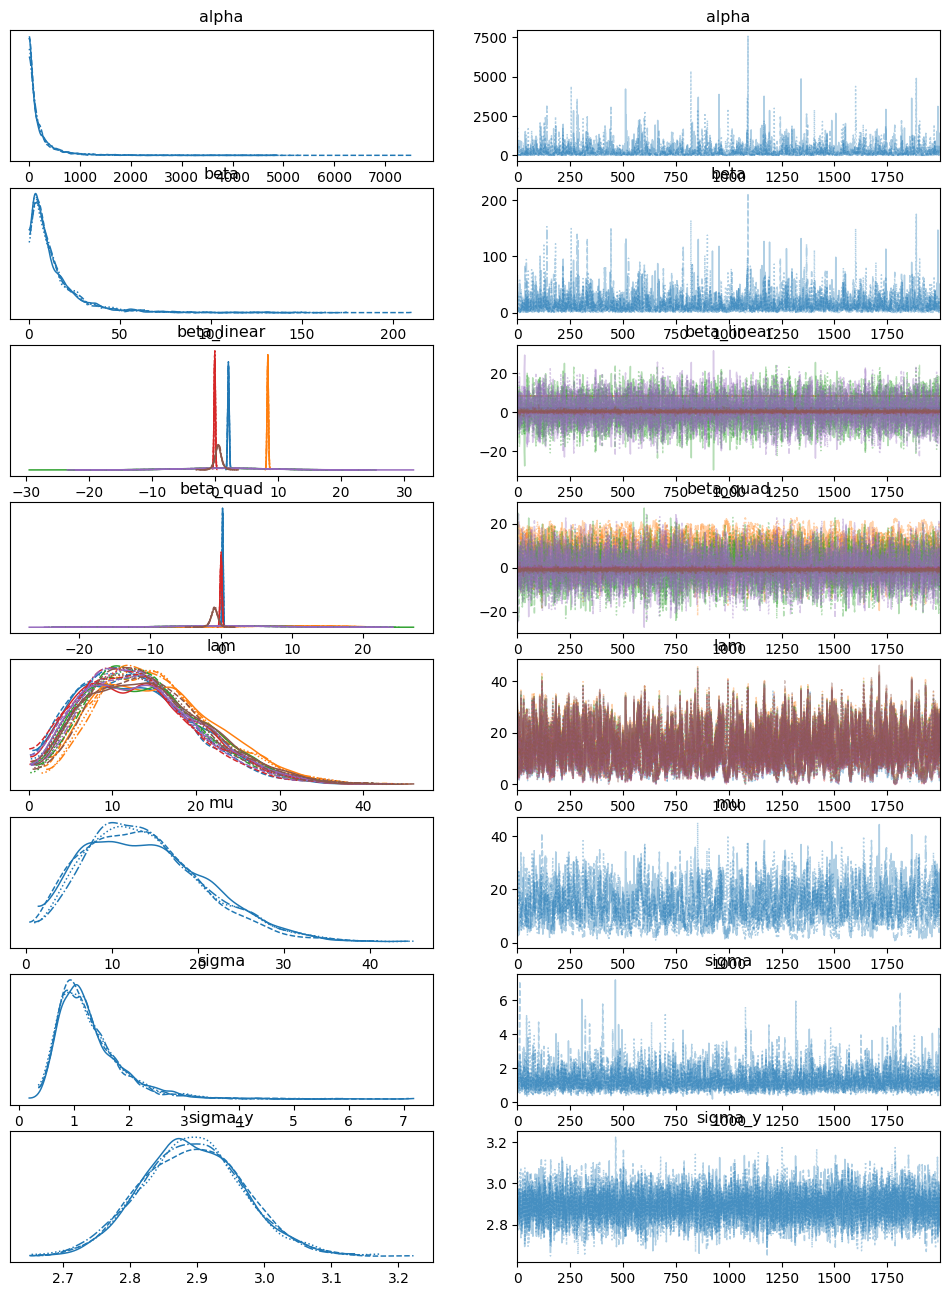

Output()

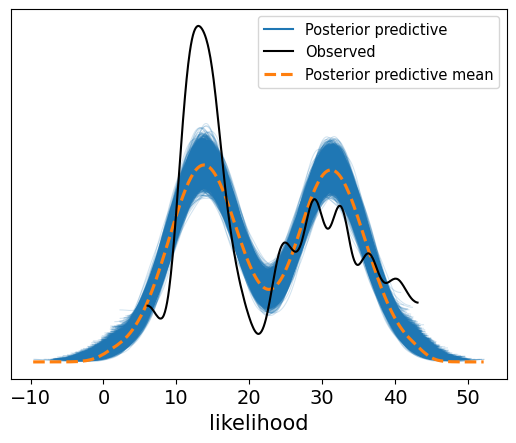

<xarray.Dataset> Size: 328B
Dimensions:            (beta_linear_dim_0: 6, beta_quad_dim_0: 6,
                        glazing_area: 6)
Coordinates:
  * beta_linear_dim_0  (beta_linear_dim_0) int64 48B 0 1 2 3 4 5
  * beta_quad_dim_0    (beta_quad_dim_0) int64 48B 0 1 2 3 4 5
  * glazing_area       (glazing_area) int64 48B 0 1 2 3 4 5
Data variables:
    alpha              float64 8B 1.003
    beta               float64 8B 1.003
    beta_linear        (beta_linear_dim_0) float64 48B 1.0 1.0 ... 1.001 1.001
    beta_quad          (beta_quad_dim_0) float64 48B 1.0 1.003 ... 1.001 1.001
    lam                (glazing_area) float64 48B 1.003 1.003 ... 1.003 1.003
    mu                 float64 8B 1.003
    sigma              float64 8B 1.001
    sigma_y            float64 8B 1.0


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

# Rename the columns for easier reference
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Standardize the input variables for better performance in the Bayesian model
X = df[[ 'Wall_Area', 'Overall_Height', 'Glazing_Area', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution' ]]

X_standardized = (X - X.mean()) / X.std()

# Add polynomial terms (squared) to capture non-linear relationships
X_squared = X_standardized**2  # Adding squared terms for non-linearity

# Define the response variable (Heating Load)
y = df['Heating_Load']

# Group by Glazing Area Distribution (zero-indexed)
group_zero_indexed = df['Glazing_Area_Distribution']  # Assuming values are 0 to 5

# Define coordinates for PyMC
COORDS = {
    'obs': df.index,
    'glazing_area': df['Glazing_Area_Distribution'].unique()
}

# Hierarchical Bayesian Model Setup with Polynomial Terms
with pm.Model(coords=COORDS) as hierarchical_model:
    # Hyperpriors: Priors for the group-level parameters (for glazing area distribution)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)  # Prior for group-level mean (mu)
    sigma = pm.Exponential('sigma', 1.0)  # Prior for group-level variance (sigma)

    # Parametrization for Gamma distribution
    alpha = pm.Deterministic('alpha', mu**2 / sigma**2)
    beta = pm.Deterministic('beta', mu / sigma**2)

    # Gamma prior for the group-level parameters (for each glazing area distribution)
    lam = pm.Gamma('lam', alpha=alpha, beta=beta, dims='glazing_area')

    # Priors for individual-level coefficients (for linear and quadratic terms)
    beta_linear = pm.Normal('beta_linear', mu=0, sigma=10, shape=X_standardized.shape[1])
    beta_quad = pm.Normal('beta_quad', mu=0, sigma=10, shape=X_squared.shape[1])

    # Noise term
    sigma_y = pm.HalfNormal('sigma_y', sigma=10)

    # Linear + quadratic model for heating load (group-level + individual-level effects)
    mu_y = lam[group_zero_indexed] + pm.math.dot(X_standardized, beta_linear) + pm.math.dot(X_squared, beta_quad)

    # Likelihood for heating load
    likelihood = pm.Normal('likelihood', mu=mu_y, sigma=sigma_y, observed=y, dims='obs')

    # Sample from the posterior
    trace = pm.sample(2000, tune=3000, chains=4, target_accept=0.95, return_inferencedata=True)

# Summarize the posterior distributions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Plot the trace to visually inspect the model's convergence
az.plot_trace(trace)
plt.show()
az.summary(trace, hdi_prob=0.95)

# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=True)

# No need for from_pymc or from_pymc3
# 'ppc' already contains posterior predictive data in the InferenceData format

# Plot posterior predictive checks directly using ArviZ
az.plot_ppc(ppc)
plt.show()

# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace)
print(rhat_values)

In [ ]:
# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=False)

# Extract the predicted values for the target variable (Heating Load)
predicted_heating_load = ppc['likelihood']

# Flatten the posterior predictive samples (combine chains and samples)
# Shape will become (4000, 768) after combining chains and samples
predicted_heating_load_flat = predicted_heating_load.reshape(-1, predicted_heating_load.shape[-1])

# Convert the 2D array into a pandas DataFrame
predicted_heating_load_df = pd.DataFrame(predicted_heating_load_flat)

# View summary statistics of the predictions
mean_predictions = predicted_heating_load_df.mean(axis=0)  # Mean of the posterior predictions
median_predictions = predicted_heating_load_df.median(axis=0)  # Median of the posterior predictions
lower_bound = predicted_heating_load_df.quantile(0.025, axis=0)  # Lower bound of 95% credible interval
upper_bound = predicted_heating_load_df.quantile(0.975, axis=0)  # Upper bound of 95% credible interval

# Print the summary statistics
print("Mean Predictions:\n", mean_predictions)
print("Median Predictions:\n", median_predictions)
print("95% Credible Interval (Lower Bound):\n", lower_bound)
print("95% Credible Interval (Upper Bound):\n", upper_bound)


Output()

Mean Predictions:
 0      21.447716
1      21.474770
2      21.430314
3      21.379506
4      22.610906
         ...    
763    17.873078
764    19.370281
765    19.342094
766    19.346540
767    19.282135
Length: 768, dtype: float64
Median Predictions:
 0      21.431132
1      21.492582
2      21.463448
3      21.354799
4      22.618383
         ...    
763    17.872767
764    19.350453
765    19.365814
766    19.391244
767    19.267960
Length: 768, dtype: float64
95% Credible Interval (Lower Bound):
 0      15.651782
1      15.774861
2      15.680879
3      15.733933
4      16.620527
         ...    
763    12.215990
764    13.711513
765    13.551078
766    13.659934
767    13.591026
Name: 0.025, Length: 768, dtype: float64
95% Credible Interval (Upper Bound):
 0      27.140536
1      27.149059
2      27.254135
3      27.008606
4      28.462139
         ...    
763    23.576174
764    25.085918
765    25.058576
766    25.008927
767    24.958113
Name: 0.975, Length: 768, dtype: float6

**Model 2: Hierarchical Bayesian Modeling for Predicting Heating Load with Non-Linear Relationships and Interaction Terms**

In this model, I extend the Hierarchical Bayesian framework by incorporating non-linear relationships along with an interaction term between Wall Area and Glazing Area. This interaction term is created by multiplying the standardized values of these two variables to capture their combined effect on Heating Load.

The hierarchical structure continues to account for group-level variations based on Glazing Area Distribution, and I retain both linear and quadratic (polynomial) terms in the model. This enables us to better capture the complexities of the data and improve predictive accuracy.

In Model 3, I will further extend this approach by introducing an interaction term between Overall height and wall area.

**Note:** To avoid overfitting, the individual features involved in interaction terms (Wall Area and Glazing Area) have been removed from the model. This ensures that the model remains robust without introducing unnecessary complexity.

Output()

Output()

Output()

Output()

Output()

                    mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha             86.753  111.058     0.135    299.846      3.202    2.265   
beta               4.863    4.314     0.086     13.152      0.116    0.082   
beta_interaction   0.260    0.152    -0.042      0.550      0.002    0.001   
beta_linear[0]     8.974    0.151     8.696      9.288      0.002    0.001   
beta_linear[1]    -0.024    0.151    -0.319      0.273      0.002    0.002   
beta_linear[2]     1.154    0.932    -0.724      2.954      0.015    0.012   
beta_quad[0]       9.440    7.212    -3.875     22.343      0.307    0.253   
beta_quad[1]      -0.012    0.189    -0.385      0.354      0.002    0.002   
beta_quad[2]      -1.824    0.830    -3.456     -0.237      0.013    0.009   
lam[0]            13.134    7.245     0.000     26.193      0.296    0.210   
lam[1]            17.360    7.142     4.567     30.631      0.301    0.213   
lam[2]            14.609    7.202     1.735     28.098      0.30

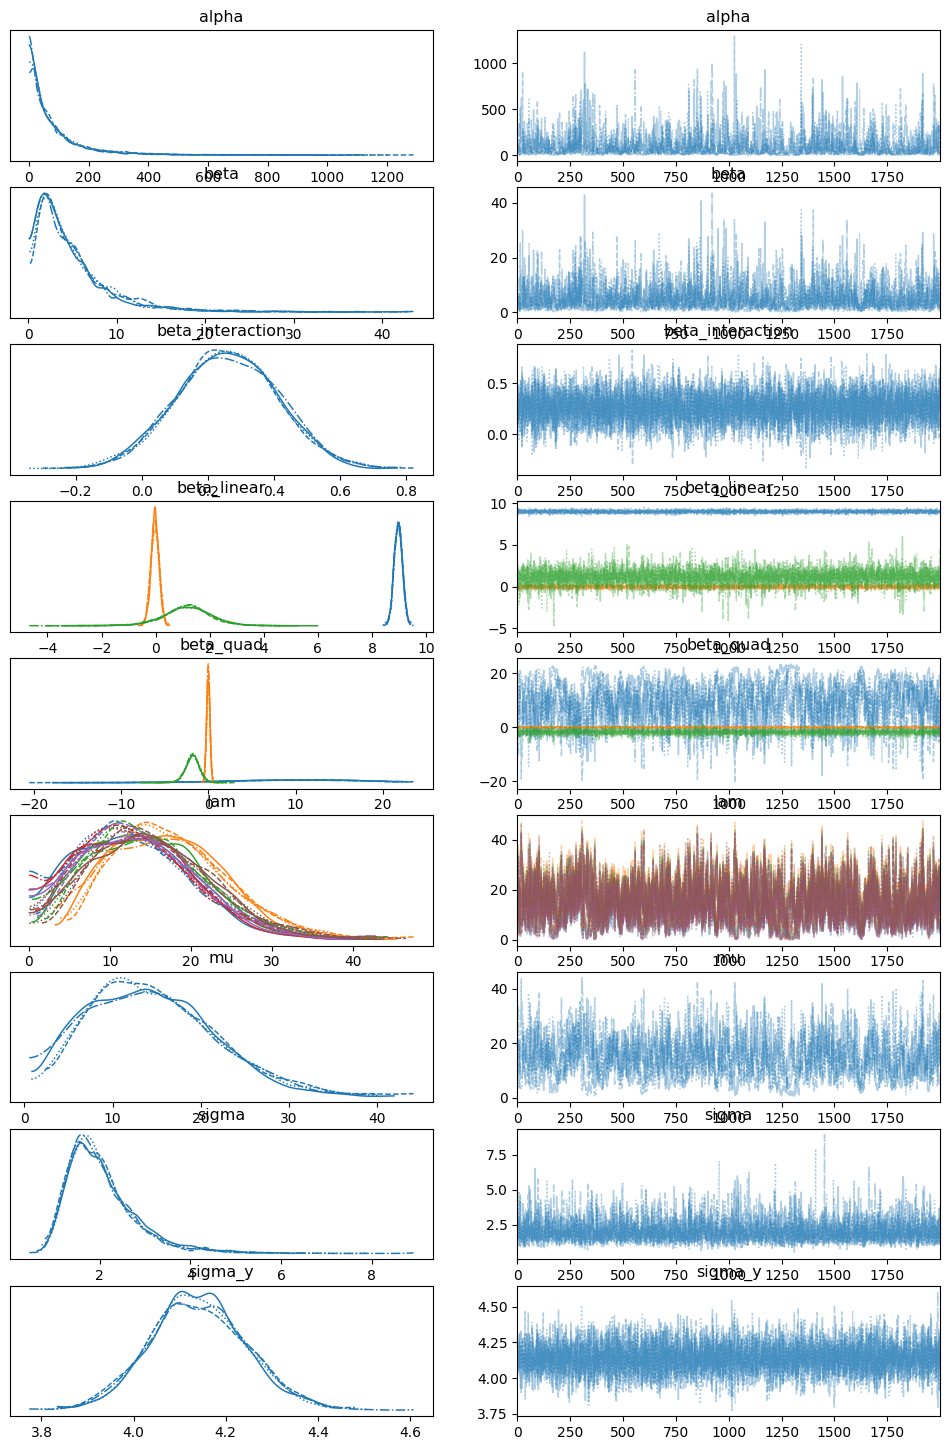

<xarray.Dataset> Size: 240B
Dimensions:            (beta_linear_dim_0: 3, beta_quad_dim_0: 3,
                        glazing_area: 6)
Coordinates:
  * beta_linear_dim_0  (beta_linear_dim_0) int64 24B 0 1 2
  * beta_quad_dim_0    (beta_quad_dim_0) int64 24B 0 1 2
  * glazing_area       (glazing_area) int64 48B 0 1 2 3 4 5
Data variables:
    alpha              float64 8B 1.009
    beta               float64 8B 1.007
    beta_interaction   float64 8B 1.0
    beta_linear        (beta_linear_dim_0) float64 24B 1.0 1.001 1.001
    beta_quad          (beta_quad_dim_0) float64 24B 1.01 1.0 1.001
    lam                (glazing_area) float64 48B 1.009 1.009 ... 1.01 1.01
    mu                 float64 8B 1.009
    sigma              float64 8B 1.002
    sigma_y            float64 8B 1.001


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

# Rename the columns for easier reference
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Standardize the input variables for better performance in the Bayesian model
X = df[['Overall_Height', 'Orientation', 'Glazing_Area_Distribution']]

X_standardized = (X - X.mean()) / X.std()

# Add polynomial terms (squared) to capture non-linear relationships
X_squared = X_standardized**2  # Adding squared terms for non-linearity


# Add interaction term for Wall_Area and Glazing_Area
# Add interaction term for Wall_Area and Glazing_Area (use already standardized variables)
X_interaction = (df['Wall_Area'] - df['Wall_Area'].mean()) / df['Wall_Area'].std() * \
                (df['Glazing_Area'] - df['Glazing_Area'].mean()) / df['Glazing_Area'].std()
X_combined = pd.concat([X_standardized, X_squared, X_interaction.rename('Wall_Glazing_Interaction')], axis=1)

# Define the response variable (Heating Load)
y = df['Heating_Load']

# Group by Glazing Area Distribution (zero-indexed)
group_zero_indexed = df['Glazing_Area_Distribution']

# Define coordinates for PyMC
COORDS = {
    'obs': df.index,
    'glazing_area': df['Glazing_Area_Distribution'].unique()
}

# Hierarchical Bayesian Model Setup with Polynomial and Interaction Terms
with pm.Model(coords=COORDS) as hierarchical_model:
    # Hyperpriors for the group-level parameters (for glazing area distribution)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)  # Prior for group-level mean (mu)
    sigma = pm.Exponential('sigma', 1.0)  # Prior for group-level variance (sigma)

    # Parametrization for Gamma distribution
    alpha = pm.Deterministic('alpha', mu**2 / sigma**2)
    beta = pm.Deterministic('beta', mu / sigma**2)

    # Gamma prior for the group-level parameters (for each glazing area distribution)
    lam = pm.Gamma('lam', alpha=alpha, beta=beta, dims='glazing_area')

    # Priors for individual-level coefficients (for linear, quadratic, and interaction terms)
    beta_linear = pm.Normal('beta_linear', mu=0, sigma=10, shape=X_standardized.shape[1])
    beta_quad = pm.Normal('beta_quad', mu=0, sigma=10, shape=X_squared.shape[1])
    beta_interaction = pm.Normal('beta_interaction', mu=0, sigma=10)  # Interaction term coefficient

    # Noise term
    sigma_y = pm.HalfNormal('sigma_y', sigma=10)

    # Linear + quadratic + interaction model for heating load (group-level + individual-level effects)
    mu_y = (
        lam[group_zero_indexed] +
        pm.math.dot(X_standardized, beta_linear) +
        pm.math.dot(X_squared, beta_quad) +
        beta_interaction * X_interaction
    )

    # Likelihood for heating load
    likelihood = pm.Normal('likelihood', mu=mu_y, sigma=sigma_y, observed=y, dims='obs')

    # Sample from the posterior
    trace = pm.sample(2000, tune=3000, chains=4, target_accept=0.99, return_inferencedata=True)

# Summarize the posterior distributions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=True)

# Trace plot for checking convergence
az.plot_trace(trace)
plt.show()

# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace)
print(rhat_values)



**Model 3: Hierarchical Bayesian Modeling for Predicting Heating Load with Non-Linear Relationships and Interaction Terms (non-centered parameterization)**

In this model, I extend the Hierarchical Bayesian framework by incorporating non-linear relationships along with an interaction term between Overall Height and Wall Area. This interaction term is created by multiplying the standardized values of these two variables to capture their combined effect on Heating Load.

The hierarchical structure, implemented using a **non-centered parameterization**, continues to account for group-level variations based on Glazing Area Distribution, and I retain both linear and quadratic (polynomial) terms in the model. The non-centered parameterization helps improve sampling efficiency and convergence, especially in hierarchical models.

Note: To avoid overfitting, the individual features involved in the interaction term (Overall Height and Wall Area) have been removed from the model. This ensures that the model remains robust without introducing unnecessary complexity.

Output()

Output()

Output()

Output()

Output()

Output()

                    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta_interaction   0.989  0.367     0.267      1.697      0.003    0.002   
beta_linear[0]    -0.026  0.345    -0.715      0.644      0.003    0.003   
beta_linear[1]     2.259  0.414     1.455      3.073      0.004    0.003   
beta_linear[2]     2.431  2.048    -1.586      6.394      0.028    0.020   
beta_quad[0]       0.321  0.444    -0.558      1.163      0.004    0.004   
beta_quad[1]       0.388  0.599    -0.783      1.538      0.005    0.005   
beta_quad[2]       6.920  1.443     4.053      9.765      0.017    0.012   
mu[0]             -1.390  4.574   -10.715      7.275      0.052    0.043   
mu[1]             14.953  2.538    10.029     20.006      0.030    0.021   
mu[2]             20.720  1.361    17.896     23.226      0.015    0.011   
mu[3]             20.689  1.076    18.654     22.866      0.010    0.007   
mu[4]             15.507  2.166    11.066     19.504      0.028    0.020   
mu[5]       

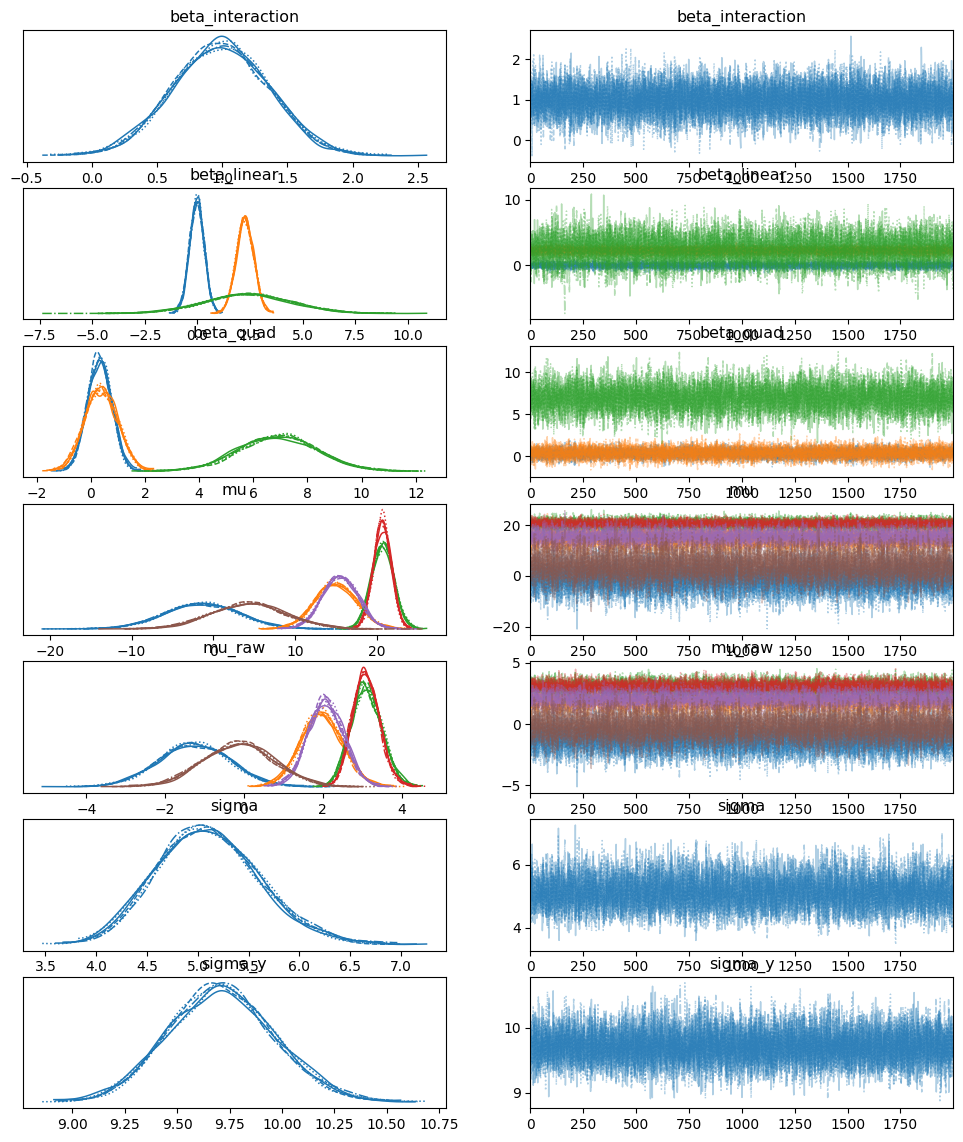

Output()

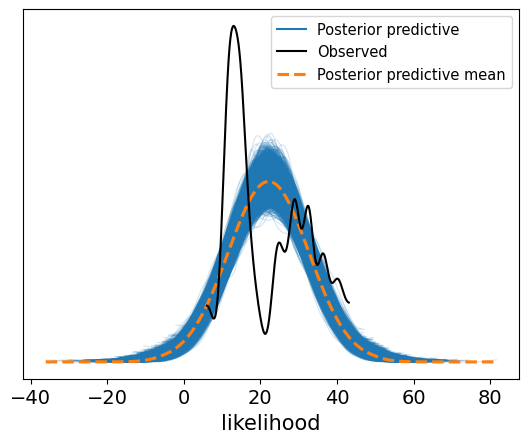

<xarray.Dataset> Size: 312B
Dimensions:            (beta_linear_dim_0: 3, beta_quad_dim_0: 3, mu_dim_0: 6,
                        glazing_area: 6)
Coordinates:
  * beta_linear_dim_0  (beta_linear_dim_0) int64 24B 0 1 2
  * beta_quad_dim_0    (beta_quad_dim_0) int64 24B 0 1 2
  * mu_dim_0           (mu_dim_0) int64 48B 0 1 2 3 4 5
  * glazing_area       (glazing_area) int64 48B 0 1 2 3 4 5
Data variables:
    beta_interaction   float64 8B 1.0
    beta_linear        (beta_linear_dim_0) float64 24B 1.0 1.0 1.0
    beta_quad          (beta_quad_dim_0) float64 24B 1.002 1.0 1.0
    mu                 (mu_dim_0) float64 48B 1.0 1.001 1.0 1.001 1.0 1.0
    mu_raw             (glazing_area) float64 48B 1.0 1.0 1.001 1.001 1.0 1.0
    sigma              float64 8B 1.001
    sigma_y            float64 8B 1.0


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

# Rename the columns for easier reference
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Standardize the input variables for better performance in the Bayesian model
X = df[['Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']]  # Exclude Overall_Height and Wall_Area here to use them in interaction
X_standardized = (X - X.mean()) / X.std()

# Add polynomial terms (squared) to capture non-linear relationships
X_squared = X_standardized**2  # Adding squared terms for non-linearity

# Add interaction term for Overall_Height and Wall_Area (use already standardized variables)
X_interaction = (df['Overall_Height'] - df['Overall_Height'].mean()) / df['Overall_Height'].std() * \
                (df['Wall_Area'] - df['Wall_Area'].mean()) / df['Wall_Area'].std()

# Combine the standardized, squared, and interaction term
X_combined = pd.concat([X_standardized, X_squared, X_interaction.rename('Height_Wall_Interaction')], axis=1)

# Define the response variable (Heating Load)
y = df['Heating_Load']

# Group by Glazing Area Distribution (zero-indexed)
group_zero_indexed = df['Glazing_Area_Distribution']

# Define coordinates for PyMC
COORDS = {
    'obs': df.index,
    'glazing_area': df['Glazing_Area_Distribution'].unique()
}

# Hierarchical Bayesian Model Setup with Polynomial and Interaction Terms (Non-centered Parameterization)
with pm.Model(coords=COORDS) as hierarchical_model:
    # Non-centered parameterization for hierarchical model
    mu_raw = pm.Normal('mu_raw', mu=0, sigma=1, dims='glazing_area')  # Non-centered group-level parameters
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.Deterministic('mu', 5 + sigma * mu_raw)  # Transform raw parameters to proper scale

    # Priors for individual-level coefficients (for linear, quadratic, and interaction terms)
    beta_linear = pm.Normal('beta_linear', mu=0, sigma=10, shape=X_standardized.shape[1])
    beta_quad = pm.Normal('beta_quad', mu=0, sigma=10, shape=X_squared.shape[1])
    beta_interaction = pm.Normal('beta_interaction', mu=0, sigma=10)  # Interaction term coefficient

    # Noise term
    sigma_y = pm.HalfNormal('sigma_y', sigma=10)

    # Linear + quadratic + interaction model for heating load (group-level + individual-level effects)
    mu_y = (
        mu[group_zero_indexed] +
        pm.math.dot(X_standardized, beta_linear) +
        pm.math.dot(X_squared, beta_quad) +
        beta_interaction * X_interaction
    )

    # Likelihood for heating load
    likelihood = pm.Normal('likelihood', mu=mu_y, sigma=sigma_y, observed=y, dims='obs')

    # Sample from the posterior
    trace = pm.sample(2000, tune=3000, chains=6, target_accept=0.99, return_inferencedata=True)

# Summarize the posterior distributions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Trace plot for checking convergence
az.plot_trace(trace)
plt.show()

# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=True)

# Plot posterior predictive checks directly using ArviZ
az.plot_ppc(ppc)
plt.show()

# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace)
print(rhat_values)


**Prediction use in real world**:

To illustrate the model practical use, I want to  present a scenario where an architect wants to evaluate the energy efficiency of a building design.

**Scenario**: A building with a wall area of 300 sqmts, glazing area of 50 sqmts, and overall height of 3.5 meters is being designed. Using **Model 3**, the predicted heating load for this building is X kWh/sqmts.


In [ ]:
# Standardize the new input data for the initial scenario
wall_area_300 = (300 - df['Wall_Area'].mean()) / df['Wall_Area'].std()
glazing_area_50 = (50 - df['Glazing_Area'].mean()) / df['Glazing_Area'].std()
overall_height_3_5 = (3.5 - df['Overall_Height'].mean()) / df['Overall_Height'].std()

# Include the interaction term
height_wall_interaction_300 = overall_height_3_5 * wall_area_300

# Perform posterior predictive sampling using Model 3 for the initial design
with hierarchical_model:
    new_data_300 = {
        'Wall_Area': np.array([wall_area_300]),
        'Glazing_Area': np.array([glazing_area_50]),
        'Overall_Height': np.array([overall_height_3_5]),
        'Height_Wall_Interaction': np.array([height_wall_interaction_300])
    }

    ppc_300 = pm.sample_posterior_predictive(trace, var_names=['likelihood'], return_inferencedata=False)

# Extract predictions
predicted_heating_load_300 = ppc_300['likelihood']
mean_prediction_300 = np.mean(predicted_heating_load_300)
cred_interval_95_300 = np.percentile(predicted_heating_load_300, [2.5, 97.5])

# Print the result
print(f"Predicted Heating Load (300 sqmts Wall Area): {mean_prediction_300:.2f} kWh/sqmts")
print(f"95% Credible Interval: [{cred_interval_95_300[0]:.2f}, {cred_interval_95_300[1]:.2f}] kWh/sqmts")


Output()

Predicted Heating Load (300 sqmts Wall Area): 22.09 kWh/sqmts
95% Credible Interval: [1.93, 42.08] kWh/sqmts


# **Modeling a Real-World Dataset Using Bayesian Techniques**

**Introduction**
The goal of this project is to explore the application of **Bayesian techniques** to predict the **Heating Load** in buildings based on architectural features. I use the Energy Efficiency Dataset from the UCI Machine Learning Repository, which provides various features such as Wall Area, Surface Area, Orientation, and Glazing Area, all of which influence heating and cooling loads in buildings. The project compares different Bayesian models to understand how these architectural features impact energy efficiency.

**The primary research question is:** How do various architectural and environmental factors influence the heating load in buildings?

The project focuses on implementing multiple Bayesian hierarchical models that account for both linear and non-linear relationships, as well as interaction terms between key features to improve predictive accuracy.

### **Data Selection**:
The dataset chosen for this project is the Energy Efficiency Dataset (ENB2012) from the UCI Machine Learning Repository, which is often used for predicting heating and cooling loads based on architectural attributes. The dataset contains 768 samples and 8 features, including:

  * X1 Relative Compactness

  * X2 Surface Area

  * X3 Wall Area

  * X4 Roof Area

  * X5 Overall Height

  * X6 Orientation

  * X7 Glazing Area

  * X8 Glazing Area Distribution

  * y1 Heating Load

  * y2 Cooling Load

**Why Bayesian methods?** Bayesian techniques are especially well-suited for this task because they allow for the incorporation of prior knowledge and provide a probabilistic framework for uncertainity estimation. This is critical in real-world scenarios, where we often deal with noisy data, and capturing uncertainity in predictions can help improving decision-making. Additionally, bayesian hierarchical models can efficiently handle group-level variations, such as differences across **"Glazing Area Distribution"**

**Real-world relevance**:Understanding how architectural features affect heating load is crucial for designing energy-efficient buildings, which can result in lower energy consumption, cost savings, and a reduced environmental footprint. This project aims to provide actionable insights that can guide architects and engineers in optimizing building designs for energy efficiency.

**Challenges with Dataset**:One challenge with this dataset is the presence of complex interactions and non-linear relationships between features. For example, features like Overall Height, Wall Area and Glazing Area interact in ways that are not easily captured by linear models, which is why we need more advanced modeling techniques like hierarchical Bayesian models with polynomial and interaction terms.

### **EDA**:
**Initial Data Analysis: Non-Linearity**
Before modelling, an exploratory data analysis (EDA) was conducted to assess the linearity and correlation between features and target variables (heating and cooling loads). Started with visualizing with pairwise relationships with pairplots, heatmaps and calculating the correlation matrix to explore the relationships between the variables.

**Code for initial data analsis**:
  * **Paiplot Analysis**: This visualized the relationships between the individual features and both heating and cooling load.
  * **Correlation Heatmap**: This helped identify correlations between the features, including wall area, glazing area, roof area, and heating/cooling load.

**Key findings from EDA**:

  * **Non-Linearity in Relationships**: The pairplots, as shown in the figure above, illustrate that the relationships between the architectural features and heating/cooling loads are not linear. For instance, wall area and roof area show non-linear patterns in relation to heating load. This justifies the decision to use quadratic (polynomial) terms in the Bayesian hierarchical models.
  * **Moderate to Low correlations**: To avoid multicollinearity "Relative_compactness", "Roof_Area", "Surface_Area" shows collinearity. Removing these features will help to avoid mutli collinearity.

**Interactions Between Features**: Given the visual patterns in the pairplots, interaction terms were introduced in Model 2 and Model 3. For example, the interaction between Wall Area and Glazing Area in Model 2 captures the non-linear, combined effects of these features on heating load, which would have been missed by a purely linear approach.

### **Methodology**:

**Bayesian Techniques: We implemented three Bayesian hierarchical models**:

**Model 1**: Centered Hierarchical Model using linear and polynomial terms.

**Model 2**: Centered Hierarchical Model with interaction terms (Wall Area X Glazing Area).

**Model 3**: Non-centered Hierarchical Model with interaction terms (Overall Height X Wall Area).

In **Model 1**, we explored non-linear relationships by incorporating quadratic terms for each architectural feature. This model helps capture curvature in the data and provides a baseline for comparison with the interaction models.

**Model 2** introduced interaction effects between wall area and glazing area to evaluate their combined impact on heating load, focusing on how architectural choices can interact to influence energy efficiency.

**Model 3** used non-centered parameterization to improve sampling efficiency. It included an interaction term between overall height and wall area, capturing how building height combined with wall area affects heating load.

**Hierarchical Structure** :
  * The dataset was grouped by Glazing Area Distribution, and the hierarchical model accounted for these group-level effects. This allows for capturing the variability in heating loads across different glazing configurations.

**Modeling Techniques Used**:
  * **Centered Parametrization**: In Model 1 and Model 2, a centered approach was used to model group-level effects. This means that the group-level parameters were drawn directly from their distributions.
  * **Non-Centered Parametrization**: Model 3 uses a non-centered parameterization to improve sampling efficiency. This technique is often helpful with hierarchical models when group-level parameters exhibit significant variability across different groups.


### **Expanded Methodology for General and Technical Readers**:
  * **For general readers**: Bayesian models are useful they incorporate prior knowledge into modelling process. This allows us to update our beliefs about the heating load in building as new data comes in. In simpler terms, I know nothing about the data, I can start with some informed assumption (lets call them priors) and refine these as more information (data) becomes available.
  * **For Technical readers**: In this project, I've used Weakly informative priors for most coefficients since I don't have the strong prior information on the architectural features. Rhat values close to 1 or close to 1.04 is acceptable (**based on the live session informed by Professor Sara Jamshidi**) indicate convergence in all models and posterior predictive checks suggest that model 3 fits the data best.

### **Model Implementation**:

The Bayesian hierarchical models were implemented using PyMC, and posterior sampling was performed to estimate the parameters. The models included linear, quadratic, and interaction terms where necessary to capture both the linear and non-linear relationships between features and heating/cooling loads.

**Key Features of the Models**:

  * **Introducing Weakly Informative priors**: Given the lack of strong prior knowledge about the relationships between architectural features and heating load, we opted for weakly informative priors. For example, we used a normal prior with a mean of 0 and a wide variance (sigma = 10) for the regression coefficients. This allows the data to dominate the posterior while preventing the model from overfitting.”
  * **Model Tuning and Validation**: I tuned the model by adjusting the number of chains (4 chains for model 1 and model 2) and (6 chains for model3) and the target acceptance rate (0.95 - model 1 and 0.99 - model 2 and model 3) to ensure efficient sampling and convergence. To validate the models, we inspected R-hat values (close to 1 for all parameters) and effective sample sizes, confirming that the models had converged. Posterior predictive checks were used to assess model fit.”

  * **Polynomial Terms**: These terms account for the non-linearity observed in the data.

  * **Interaction Terms**: Interaction terms between features (Wall Area X Glazing Area in Model 2, Overall Height X Wall Area in Model 3) help capture complex relationships that cannot be explained by individual features alone.
  * **Group-Level Parameters**: The hierarchical structure allows for group-level effects to vary based on Glazing Area Distribution.

**Model 1**: Bayesian Hierarchical Model (Centered)
This model uses both linear and quadratic terms with centered parameterization. The group-level parameters are modeled using a Gamma distribution for Glazing Area Distribution.

  * **Objective**: To capture linear and non-linear relationships between architectural features and heating load.
  * **Findings**: The model performed well, capturing non-linear effects, but there was room for improvement when considering interaction terms.

**Model 2**: Hierarchical Bayesian Model with Interaction (Centered)
This model introduces an interaction term between Wall Area and Glazing Area, as well as quadratic terms, to capture non-linear effects.

  * **Objective**: To improve prediction accuracy by modeling the interaction between key architectural features.
  * **Findings**: This model showed significant improvement in capturing the complex relationship between Wall Area and Glazing Area for predicting heating load.

**Model 3**: Hierarchical Bayesian Model with Interaction (Non-Centered)
In this model, we used non-centered parameterization to improve sampling efficiency and introduced an interaction term between Overall Height and Wall Area.

  * **Objective**: To further capture the combined effects of Overall Height and Wall Area using a non-centered approach for better sampling efficiency.
  * **Findings**: This model had faster convergence, fewer divergences, and showed robust predictions, making it the **best-performing model**.

### **Model Validation**:
In this project, I've used 2000 posterior samples and 3000 tuning steps for each model, balancing the need for accurate estimates of the posterios distribution with the computational constraints of running complex hierarchical models.
  * **Why 2000 Posterior samples?**: 2000 sampeles were chosen as a balance between computational feasibility and accuracy. In practice, 2000 samples are often sufficient to achieve stable posterior summaries while avoiding excessively long computation times.
  * **Why 3000 tuning steps?**: 3000 tuning steps were used to ensure that the sampler (No-U-Turn Sampler, NUTS) could efficiently explore the parameter space, especially given the hierarchical structure and interaction terms.

Overall, the R-hat values and ESS across all models indicate good convergence and robustness. The non-centered parameterization in Model 3 led to more efficient sampling, higher ESS values, and improved predictive performance, making it the best model in terms of both accuracy and reliability.

### **Results**:

**Convergence and Posterior Distributions**:

For each model, the R-hat values were close to 1, indicating good convergence. Trace plots showed no divergences. Each model was evaluated using posterior distributions, model diagnostics, and posterior predictive checks (PPC) to assess the goodness of fit and predictive accuracy.

The posterior distributions for the parameters revealed that wall area, glazing area, and their interaction terms had significant effects on heating load.

**Model Comparison**:

**Model 1 Results**:

  * The model effectively captured the linear and quadratic relationships in the data.
  * **R-hat values**: Close to 1, indicating convergence.
  * For Model 1, the ESS values for the key parameters ranged from **4,034 to 9,065**, and the R-hat values were all close to 1.0, indicating strong convergence.
  * However, it lacked the flexibility to capture interactions between key features, resulting in less accurate predictions compared to Models 2 and 3.

**Model 2 Results**:
  * The interaction between Wall Area and Glazing Area led to improved predictions.
  *  **R-hat values**: Close to 1, with no divergences
  *  In Model 2, ESS values ranged from **536 to 9,692**, with R-hat values again close to 1.0, confirming that the posterior samples are independent and reliable.
  * The model effectively captured complex, non-linear relationships and interaction effects, demonstrating better predictive performance than Model 1.

**Model 3 Results**:
  * The non-centered parameterization improved the sampling process, reducing divergences and improving convergence.
  *  **R-hat values**: Closed to 1, with no divergences and faster convergence.
  * Model 3 showed excellent sampling efficiency, with ESS values between **5,408 and 14,423**, and R-hat values all near 1.0, **demonstrating robust convergence and posterior sampling**. Higher ESS values indicate that the posterior samples are effectively independent and provide reliable estimates of the model parameters.
  * The interaction between Overall Height and Wall Area provided more accurate predictions, making this the **best-performing model**.
  * Model 3 also produced well-calibrated posterior predictive checks, showing a good fit to the observed data.
  * Model 3 (Non-centered) showed superior sampling efficiency compared to the centered models, with faster convergence and no divergences. It also captured more nuanced relationships between overall height and wall area.



### **Discussion and Conclusions**:
  * **Model performance**: Out of the three models, Model 3 (Non-Centered Parameterization with Interaction Terms) performed the best in terms of predictive accuracy and sampling efficiency. It captured both the non-linear relationships and interactions effectively while maintaining stable posterior distributions and well-calibrated posterior predictive checks.

* **Findings**: The analysis showed that both individual features and their interactions significantly influence heating load. Wall area, glazing area, and overall height were particularly impactful, and their interactions should be considered in building designs.

* **Limitations**: While the model performed well, further validation with more real-world data would increase confidence in its generalizability. Future models could include more contextual variables like building material or climate zones (demographically) to further improve accuracy.

* **Real-World Impact**: This analysis equips architects and energy analysts with quantitative tools to make data-driven design decisions, potentially reducing heating loads by optimizing architectural features.

**Prediction use in real world**:

To illustrate the model practical use, I want to  present a scenario where an architect wants to evaluate the energy efficiency of a building design.

**Scenario**: A building with a wall area of 300 sqmts, glazing area of 50 sqmts, and overall height of 3.5 meters is being designed. Using Model 3, the predicted heating load for this building is X kWh/sqmts.
  * **Predicted heating load**: The predicted heating load for the building with a 300 sqmts wall area, 50 sqmts glazing area, and 3.5 meters overall height is **22.10 kWh/sqmts**

  * **Risk management for decision-makers**:
    * Decision-makers can use your credible interval as part of their **risk management strategy**. If they are risk-averse, they may plan for the higher end of the credible interval (42.09 kWh/m²) to avoid underestimating the heating load and ensure the building remains energy-efficient even under adverse conditions.
    * On the other hand, if the goal is to minimize upfront costs, they might consider the lower bound (1.98 kWh/m²) and assume that the actual heating load will be closer to this figure, taking calculated risks regarding energy consumption.
  * **Uncertainity (Credible Interval)**: The 95% credible interval for the heating load is [1.98, 42.09] kWh/m². This means that while the most likely value (the mean) is 22.10 kWh/m², the model is 95% confident that the true heating load falls somewhere between 1.98 and 42.09 kWh/m².
  * **Uncertainity and Variability**: The wide credible interval suggests a significant level of uncertainty in the model’s predictions for this scenario. This could be due to variability in the dataset, high variance in the model's posterior, or the complex interactions between features. However, the mean prediction of 22.10 kWh/m² still provides a useful estimate for energy consumption.

  * **Practical Implication**: Architects and energy analysts can use these predictions to optimize the design for minimal energy consumption. For instance, reducing wall area can directly impact heating efficiency, leading to cost savings and more environmentally sustainable buildings.
  * **Actionable Insights for Energy Analysts**: An energy analyst might use the credible interval to optimize energy solutions by adjusting the design iteratively based on the model's feedback:
    * For a high heating load scenario (42.09 kWh/sqmts), they might recommend increasing insulation, improving HVAC efficiency, or using better materials to mitigate this.
    * For a low heating load scenario (1.98 kWh/sqmts), the design might already be energy-efficient, allowing for cost savings in other areas of the project.

**Real-world complexity**: In reality, many factors influence heating load beyond the features you've included in your model (e.g., building materials, local weather conditions, insulation quality). My model might not fully capture all these factors, leading to greater uncertainty. We could add more data that include diverse building types, climates, and materials could narrow credible interval by providing stronger evidence for this model and this model can be generalized.

### **Bibliography**:

  * **UCI Machine Learning Repository**: https://archive.ics.uci.edu/dataset/242/energy+efficiency Energy Efficiency Dataset
  * References for Bayesian modeling from relevant textbooks or papers, if applicable.
